In [3]:
%pip install numpy
%pip install matplotlib
%pip install scikit-optimize
%pip install gpflow

0.0 % done
10.0 % done
20.0 % done
30.0 % done
40.0 % done
50.0 % done
60.0 % done
70.0 % done
80.0 % done
90.0 % done
Finished Evaling a GP


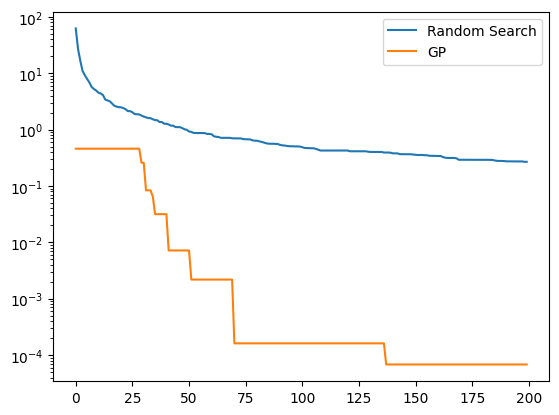

In [ ]:
from skopt.benchmarks import branin as _branin
import numpy as np
import matplotlib.pyplot as plt
import gpflow
from gpflow.kernels import Matern52 as mt52
from skopt import gp_minimize
from scipy.special import erf

class FuncToMinimise():
    def __init__(self):
        self.regret_arr = []
        self.num_evals = 0
    
    def eval(self, x):
        print('This is a base class please specify a child')
        return

class Branin(FuncToMinimise):
    def __init__(self):
        super().__init__()
        self.optimal_val = 0.397887
        self._eval_points = []
        self._eval_vals = []
    
    def _update_regret(self):
        if self.regret_arr:
            regret = min(self.regret_arr[-1], abs(self.optimal_val-self._eval_vals[-1]))
        else:
            regret = abs(self.optimal_val-self._eval_vals[-1])
        self.regret_arr.append(regret)

    def eval(self, x):
        self.num_evals += 1
        self._eval_points.append(x)
        self._eval_vals.append(_branin(x))
        self._update_regret()
        return self._eval_vals[-1]

# maybe limits should be a dict not an array of tuple since i will always assume
# continuous
class DefaultMethodClass():
    def __init__(self, func_class,
                 limits
                 ):
        self.method_name = 'Default Method Class'


        self.X_train = []
        self.y_train = []

        self.func_obj = func_class()

        self.limits = limits
        self.dims = len(limits)
        self.limit_difs = [abs(l1-l2) for l1,l2 in limits]
        self.limit_mins = [min(l1,l2) for l1, l2 in limits]

        return
    
    def get_regret(self):
        if self.func_obj.regret_arr:
            return np.array(self.func_obj.regret_arr)
        else:
            print('Funciton to minimise not given or Search method')

    def eval_sample(self, sample):
        try:
            self.X_train = np.vstack((self.X_train, sample))
            self.y_train = np.vstack((self.y_train , self.func_obj.eval(sample)))
        except:
            self.X_train = sample
            self.y_train = self.func_obj.eval(sample)
        


class RandomSearch(DefaultMethodClass):
    def __init__(self, func_class = FuncToMinimise,
                 n_iters = 200,
                 limits : list[tuple[float]] = [(-5.0,10.0),(0.0,15.0)]):
        
        super().__init__(func_class, limits)

        self.method_name = "Random Search"

        self.n_iters = n_iters
        self.iter_func_evals()
        
    def gen_samples(self):
        samples = (np.random.rand(self.n_iters, self.dims) * self.limit_difs) + self.limit_mins
        return samples
    
    def iter_func_evals(self):
        samples = self.gen_samples()
        for x in samples:
            self.eval_sample(x)


class NormalGp(DefaultMethodClass):
    def __init__(self, func_class = FuncToMinimise,
                 n_iters = 100,
                 n_random_evals = 20,
                 limits : list[tuple[float]] = [(-5.0,10.0),(0.0,15.0)]):
        
        super().__init__(func_class, limits)

        self.n_iters = n_iters - n_random_evals

        self.initial_random_evals(n_random_evals)

        self.iter_func_evals()

        self.method_name = "GP"

    
    def initial_random_evals(self, n_rand):
        samples = (np.random.rand(n_rand, self.dims) * self.limit_difs) + self.limit_mins
        for x in samples:
            self.eval_sample(x)

    def incumbent(self):
        return min(self.y_train)
    
    def expected_improvement(self, x, kappa = 0.0):
        x = np.array([x])
        incumbent = self.incumbent()
        mu_y, sd_y = self.model.predict_f(x)
        gamma_y = (mu_y - (incumbent + kappa))/ sd_y
        tmp_erf = erf(gamma_y / np.sqrt(2))
        tmp_ei_no_std = 0.5*gamma_y * (1 + tmp_erf) \
            + np.exp(-gamma_y**2/2)/np.sqrt(2*np.pi)
        ei = sd_y * tmp_ei_no_std
        return float(ei)
    
    def gen_sample(self):
        """
        make a new gp over the curr dataset, optimize it with scipy optimize
        choose new x* inside the limits
        evaluate that point - which will automatically add it to the dataset
        exit return nothing
        """
        self.model = gpflow.models.GPR(
            (self.X_train, self.y_train),
            kernel = mt52()
        )
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.model.training_loss, self.model.trainable_variables)
        
        res = gp_minimize(self.expected_improvement,self.limits,n_calls=40)
        return res.x

    def iter_func_evals(self):
        for i in range(self.n_iters):
            if i%(self.n_iters//10) == 0:
                print(f'{i/(self.n_iters)*100} % done')
            sample = self.gen_sample()
            self.eval_sample(sample)
        print('Finished Evaling a GP')

class AverageMethod():
    def __init__(self, 
                 method_class : DefaultMethodClass,
                 func_class = FuncToMinimise,
                 n_method_instances : int = 30):
        self.method_objs = [method_class(func_class = func_class) for _ in range(n_method_instances)]
        self.sum_regret = []
        self.get_sum_regret()

        self.mean_regret = self.sum_regret / n_method_instances

    def get_sum_regret(self):
        self.sum_regret = self.method_objs[0].get_regret()
        for meth in self.method_objs[1:]:
            self.sum_regret += meth.get_regret()

    def get_result(self):
        return {'name': self.method_objs[0].method_name,
                'regret':self.mean_regret}


def plot_results(results):
    for result in results:
        plt.plot(result['regret'], label=result['name'])
        plt.legend()
    plt.yscale(value="log")
    plt.plot()

def main():
    results_arr = []
    rs1_averaged = AverageMethod(method_class=RandomSearch,
                                func_class=Branin,
                                n_method_instances=100)
    results_arr.append(rs1_averaged.get_result())
    rs2_averaged = AverageMethod(method_class=NormalGp,
                                func_class=Branin,
                                n_method_instances=1)
    results_arr.append(rs2_averaged.get_result())

    plot_results(results_arr)
    return results_arr

if __name__ == '__main__':
    results_arr = main()